# Approach 2

In [ ]:
import shutil


# Check if this gets executed in google colab.
# If so, then we need to install pip packages and clone the repo and data
try:
    import google.colab
except ImportError:
    IN_COLAB = False
else:
    IN_COLAB = True


if IN_COLAB:
    !git clone https://github.com/DavidWild02/BachelorThesis-ML-Gene-Interactions.git
    %cd ./BachelorThesis-ML-Gene-Interactions

    # copy data from drive folder.
    from google.colab import drive
    drive.mount('/content/drive')
    shutil.copytree("/content/drive/MyDrive/DavidWildBachelorthesis/data", "./data", dirs_exist_ok=True)

# install packages manually, because IPython and others cannot be installed, because that crashes the runtime
!pip install matplotlib numpy pandas seaborn anndata scanpy torch scikit-learn scipy tqdm scikit-image 

Cloning into 'BachelorThesis-ML-Gene-Interactions'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 142 (delta 76), reused 89 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 6.32 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/BachelorThesis-ML-Gene-Interactions
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
  

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import numpy.typing as npt
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

np.random.seed(42) # set seed to make reproducible outputs

In [3]:
adata = sc.read_h5ad("./data/subdom_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 2671 × 13144
    obs: 'n_genes_by_counts', 'total_counts', 'clusters', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ct_gene_corr', 'ct_correlates'
    uns: 'clusters_colors', 'clusters_sizes', 'ct_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'log_tpm', 'spliced', 'tpm', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
# Replace zeros with small eta, to avoid divisions by 0
eta = 1e-10
adata.X[adata.X == 0.] = eta

adata.to_df().head()

,SUB2.g1,SUB2.g2,SUB2.g3,SUB2.g4,SUB2.g5,SUB2.g6,SUB2.g7,SUB2.g8,SUB2.g9,SUB2.g10,...,SUB2.g13135,SUB2.g13136,SUB2.g13137,SUB2.g13138,SUB2.g13139,SUB2.g13140,SUB2.g13141,SUB2.g13142,SUB2.g13143,SUB2.g13144
AAACCCAAGGACAGCT-1,0.009687,-1.032545,-1.566363,1.018223,-0.933981,-0.410398,-0.349553,-0.444472,-0.132447,-0.567418,...,1.000000e-10,1.000000e-10,1.000000e-10,-0.293056,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,-0.365098,-0.652811
AAACCCAAGGGTTTCT-1,1.598354,-0.300789,-0.202161,-0.002592,0.181964,0.269252,-0.393041,0.037609,0.115123,-0.754939,...,1.000000e-10,1.000000e-10,1.000000e-10,-0.192047,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,-0.296943,-0.677305
AAACCCACAAATGGTA-1,-0.777102,-0.792809,-1.281675,1.262175,-0.185155,-0.726397,-0.455605,-0.671795,-0.448440,-0.868259,...,1.000000e-10,1.000000e-10,1.000000e-10,-0.315716,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,-0.205751,0.327006
AAACCCATCGAGAAGC-1,0.696619,-0.306533,0.700373,-1.587061,-0.054666,0.263420,-0.105024,0.250046,0.661372,-0.186924,...,1.000000e-10,1.000000e-10,1.000000e-10,-0.300775,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,-0.310817,-0.878208
AAACCCATCTTGTTAC-1,-1.319795,-1.191836,-1.658409,1.626106,-0.142163,-1.176196,-0.391015,-0.537126,-0.254368,-0.777899,...,1.000000e-10,1.000000e-10,1.000000e-10,-0.301799,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,-0.303617,-0.420889


In [5]:
df_grn = pd.read_csv("./data/transcription_factor_adjacency_matrix.csv", index_col="gene_ids")
df_grn = df_grn.transpose()
df_grn.head()

gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SUB2.g231,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
SUB2.g755,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
SUB2.g902,1,1,1,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
SUB2.g924,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


## Approach 2.1 - Similarity between relative changes of means

In [ ]:
from data_utils import extract_samples_of_cell_cluster
from methods import calculate_mean_change_similarity_matrix, calculate_mmdd_similarity_matrix

cluster_a_id = "7" # stem cells
cluster_b_id = "0" # transition cells
cluster_a = extract_samples_of_cell_cluster(adata, cluster_a_id)
cluster_b = extract_samples_of_cell_cluster(adata, cluster_b_id)

# Filter out only those genes used in the GRN. Avoid unnecessary computation
gene_indices = pd.unique(df_grn.index.append(df_grn.columns))
cluster_a = cluster_a.loc[:, gene_indices]
cluster_b = cluster_b.loc[:, gene_indices]

similarity_matrix = calculate_mean_change_similarity_matrix(cluster_a.values, cluster_b.values)
df_similarity_mean_change = pd.DataFrame(similarity_matrix, index=gene_indices, columns=gene_indices)
display(df_similarity_mean_change.head())

,SUB2.g8,SUB2.g231,SUB2.g755,SUB2.g902,SUB2.g924,SUB2.g940,SUB2.g1013,SUB2.g1081,SUB2.g1118,SUB2.g1198,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,1.000000,-0.247332,-0.362465,0.445421,-0.870464,-0.517489,0.320999,-0.023565,0.353407,0.404589,...,0.143572,0.000003,0.000003,0.654117,0.612221,0.195182,0.790806,0.334613,0.246729,0.227296
SUB2.g231,-0.247332,1.000000,0.682361,-0.110167,0.215293,0.477946,-0.079393,0.005828,-0.087409,-0.100068,...,-0.580485,-0.000010,-0.000010,-0.378115,-0.151422,-0.789151,-0.195592,-0.739159,-0.997561,-0.918993
SUB2.g755,-0.362465,0.682361,1.000000,-0.161449,0.315512,0.700430,-0.116351,0.008542,-0.128098,-0.146649,...,-0.396100,-0.000007,-0.000007,-0.554128,-0.221909,-0.538486,-0.286639,-0.923159,-0.680697,-0.627085
SUB2.g902,0.445421,-0.110167,-0.161449,1.000000,-0.511705,-0.230500,0.720665,-0.052905,0.793424,0.908330,...,0.063950,0.000001,0.000001,0.291357,0.727548,0.086938,0.563249,0.149043,0.109898,0.101242
SUB2.g924,-0.870464,0.215293,0.315512,-0.511705,1.000000,0.450455,-0.368768,0.027072,-0.405999,-0.464797,...,-0.124974,-0.000002,-0.000002,-0.569385,-0.703328,-0.169899,-0.908488,-0.291268,-0.214768,-0.197853


In [ ]:
refined_grn_mean_change = pd.DataFrame(np.zeros(df_grn.shape), index=df_grn.index, columns=df_grn.columns)
mask = df_grn == 1
refined_grn_mean_change[mask] = df_similarity_mean_change.loc[df_grn.index, df_grn.columns][mask]
display(refined_grn_mean_change.head())

gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0.000000,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g231,0.000000,0.0000,0.000000,0.0,0.0,0.166565,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,-0.151422,-0.789151,0.0,0.000000,0.000000,0.000000
SUB2.g755,0.000000,0.0000,-0.766945,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,-0.554128,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g902,0.052816,0.1951,0.210510,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000001,0.291357,0.727548,0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g924,0.000000,0.0000,-0.411389,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.169899,0.0,-0.291268,-0.214768,-0.197853


## Approach 2.2 - Maximum mean difference discrepancy

In [10]:
# Only use a subset of the samples from the clusters, because else it takes ages to compute
cluster_a_samples = np.random.permutation(cluster_a.values)[:100]
cluster_b_samples = np.random.permutation(cluster_b.values)[:100]

similarity_matrix = calculate_mmdd_similarity_matrix(cluster_a_samples, cluster_b_samples)
df_similarity_mmdd = pd.DataFrame(similarity_matrix, index=gene_indices, columns=gene_indices)
display(df_similarity_mmdd.head())

Calculating mean kernel matrix...: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


,SUB2.g8,SUB2.g231,SUB2.g755,SUB2.g902,SUB2.g924,SUB2.g940,SUB2.g1013,SUB2.g1081,SUB2.g1118,SUB2.g1198,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,1.000000,0.759060,0.871152,-0.834900,0.920318,0.909391,0.914841,0.948201,0.933874,0.975441,...,-0.904113,0.879922,0.879922,0.939396,0.934954,-0.852545,-0.852594,-0.818113,-0.842075,-0.794363
SUB2.g231,0.759062,1.000000,0.826041,-0.825141,0.811466,0.809309,0.823349,0.799281,0.705506,0.776724,...,-0.800472,0.832005,0.832005,0.802951,0.810532,-0.677109,-0.813052,-0.783775,-0.672596,-0.644812
SUB2.g755,0.871153,0.826038,1.000000,-0.806306,0.943196,0.959349,0.904059,0.875680,0.826005,0.893245,...,-0.862607,0.854864,0.854864,0.888481,0.886232,-0.759621,-0.813865,-0.771106,-0.752988,-0.702796
SUB2.g902,-0.834901,-0.825141,-0.806308,1.000000,-0.841319,-0.816059,-0.890798,-0.876916,-0.778362,-0.843826,...,0.915341,0.947359,0.947359,-0.885560,-0.893568,0.829320,0.978213,0.955895,0.826883,0.813490
SUB2.g924,0.920324,0.811464,0.943207,-0.841319,1.000000,0.966760,0.949205,0.920941,0.864233,0.944363,...,-0.909002,0.893611,0.893611,0.941552,0.936095,-0.810744,-0.853412,-0.812170,-0.803728,-0.753943


In [11]:
refined_grn_mmdd = pd.DataFrame(np.zeros(df_grn.shape), index=df_grn.index, columns=df_grn.columns)
mask = df_grn == 1
refined_grn_mmdd[mask] = df_similarity_mmdd.loc[df_grn.index, df_grn.columns][mask]
display(refined_grn_mmdd.head())

gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SUB2.g231,0.000000,0.000000,0.000000,0.0,0.0,0.689554,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.810532,-0.677109,0.0,0.00000,0.000000,0.000000
SUB2.g755,0.000000,0.000000,-0.779639,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.888481,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
SUB2.g902,0.961048,0.919386,0.971225,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.947359,-0.885560,-0.893568,0.000000,0.0,0.00000,0.000000,0.000000
SUB2.g924,0.000000,0.000000,-0.817678,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.810744,0.0,-0.81217,-0.803728,-0.753943


## 3. Activation Score

Description of the activity score from the paper:

The input to the activity score
workflow is the expression profile of the cell and the regulon (i.e., the target genes
connected to the given driver gene along the weights for each edge), and the output
is the relative activity of this regulon in the cell. Note that in the objective of Eq. 2,
the weights are directly comparable across drivers for a given target gene, but not
across targets for a given driver since the expression for different targets may vary.
Hence, we first normalize the incidence matrices W for each driver gene (i.e., each
row) by dividing each element by the norm of the corresponding target expression.
Next, for each cell, we order the normalized weights by the expression of the target
genes in the cell. We denote the resulting normalized and ordered weight matrix by
bW. We then compute the cumulative sum of the ordered weights. The activity score
of the considered driver gene in the cell is then defined by the normalized area
under the cumulative sum curve

In [ ]:
from methods import activation_score

# This function is not very useful. Try to plot it somehow differently
def plot_activity_score_across_cells(adata, df_activity_scores_cluster, gene_name, cell_group_id):
    mask_obs = adata.obs["clusters"].values == cell_group_id

    activity_scores = np.zeros((adata.n_obs,))
    activity_scores[mask_obs] = df_activity_scores_cluster.loc[:, gene_name]
    adata.obs["activity_score"] = activity_scores

    sc.pl.umap(adata, color="activity_score", mask_obs=mask_obs, cmap="viridis",
               vmin=0, vmax=1, title=f"Activity score for {gene_name} in cluster {cell_group_id}")


def plot_activity_score_heatmap_cell_group(df_activity_scores_cluster):
    sns.heatmap(df_activity_scores_cluster, vmin=0., vmax=1., cmap="viridis")
    plt.title("activity scores")
    plt.show()

def plot_expression_level_heatmap_cell_group(df_expression_levels_cluster):
    sns.heatmap(df_expression_levels_cluster, vmin=-1., vmax=1., cmap="viridis")
    plt.title("expression levels")
    plt.show()

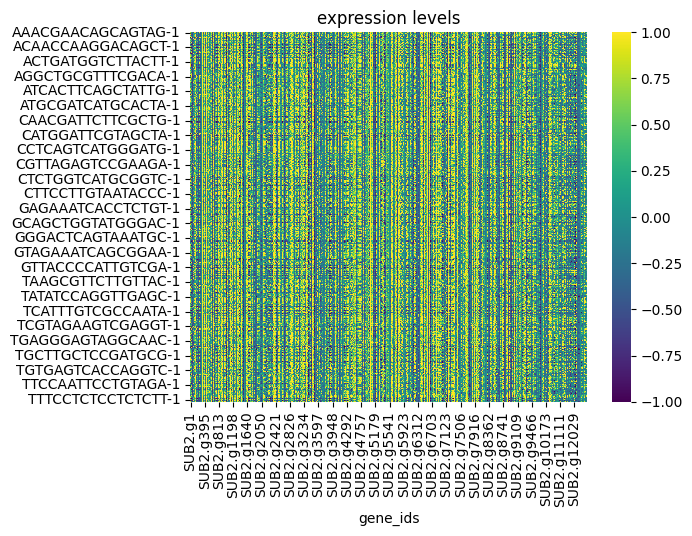

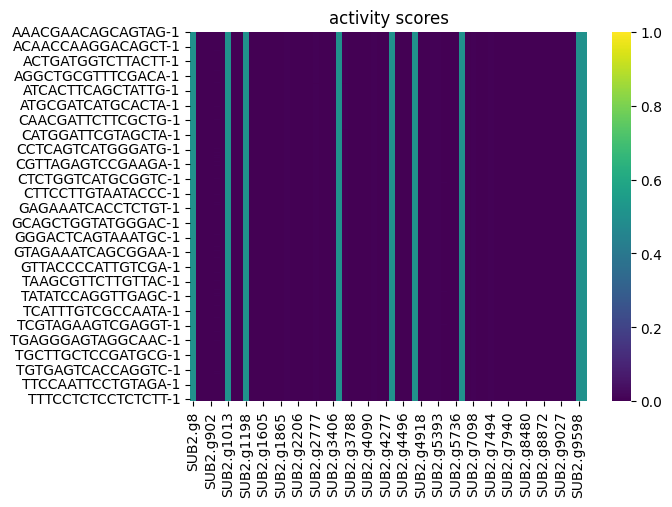

In [16]:
grn = refined_grn_mean_change
cluster_b_target_genes = cluster_b.loc[:, grn.columns]
previous_activation_scores_cell_group_b = activation_score(cluster_b_target_genes.values, grn.values)

index_obs = cluster_b_target_genes.index
index_driver_genes = grn.index
df_activation_scores_b = pd.DataFrame(previous_activation_scores_cell_group_b, index=index_obs, columns=index_driver_genes)

plot_expression_level_heatmap_cell_group(cluster_b_target_genes)
plot_activity_score_heatmap_cell_group(df_activation_scores_b)